# VacationPy
---

## Starter Code to Import Libraries and Load the Weather and Coordinates Data

In [2]:
# Dependencies and Setup
import hvplot.pandas
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors  
import plotly.express as px

# Import API key
from api_keys import geoapify_key

In [3]:
# Load the CSV file created in Part 1 into a Pandas DataFrame
city_data_df = pd.read_csv("output_data/cities.csv")

# Display sample data
city_data_df.head(5)

,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,0,iqaluit,63.7506,-68.5145,-29.06,61,75,9.77,CA,1734642125
1,1,udachny,66.4167,112.4000,-19.33,92,99,2.28,RU,1734642126
2,2,port-aux-francais,-49.3500,70.2167,4.83,88,100,7.20,TF,1734642127
3,3,progreso,21.2833,-89.6667,25.80,73,93,4.97,MX,1734642128
4,4,port elizabeth,-33.9180,25.5701,20.17,96,100,6.69,ZA,1734642129


---

### Step 1: Create a map that displays a point for every city in the `city_data_df` DataFrame. The size of the point should be the humidity in each city.

In [29]:
%%capture --no-display
# Create a color mapping for each city
unique_cities = city_data_df['City'].unique()
colors = plt.cm.get_cmap('tab10', len(unique_cities))  

# Create a color mapping dictionary
color_mapping = {city: colors(i) for i, city in enumerate(unique_cities)}

# Convert RGBA colors to hex format for hvplot
color_mapping = {city: mcolors.rgb2hex(colors(i)[:3]) for i, city in enumerate(unique_cities)}

# Step 2: Add a new column to the DataFrame for colors
city_data_df['Color'] = city_data_df['City'].map(color_mapping)

#Configure the map plot with unique colors for each city
map_plot = city_data_df.hvplot.points(
    'Lng', 'Lat', 
    size='Humidity', 
    color='Color',  
    title='City Humidity Map',
    hover_cols=['City', 'Country'],
    legend='top_right',  
    xlabel='Longitude',  
    ylabel='Latitude'    
)



# Display the map
map_plot

:Points   [Lng,Lat]   (Color,Humidity,City,Country)

### Step 2: Narrow down the `city_data_df` DataFrame to find your ideal weather condition

In [7]:
# Narrow down cities that fit criteria and drop any results with null values
# Ideal weather conditions
ideal_temp_min = 21  
ideal_temp_max = 27  
ideal_wind_speed = 4.5  
ideal_cloudiness = 0  

filtered_city_data_df = city_data_df[
    (city_data_df['Max Temp'] > ideal_temp_min) &
    (city_data_df['Max Temp'] < ideal_temp_max) &
    (city_data_df['Wind Speed'] < ideal_wind_speed) &
    (city_data_df['Cloudiness'] == ideal_cloudiness)  
]

filtered_city_data_df.insert(0, 'Order Number', range(1, len(filtered_city_data_df) + 1))

# Drop any rows with null values and column with color 
filtered_city_data_df = filtered_city_data_df.dropna()
filtered_city_data_df = filtered_city_data_df[['City_ID', 'City_ID', 'City', 'Lat', 'Lng', 'Max Temp', 'Humidity', 'Cloudiness', 'Wind Speed', 'Country', 'Date']]

# Display sample data
filtered_city_data_df

,City_ID,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
17,17,17,pamandzi,-12.7967,45.2794,26.88,78,0,2.06,YT,1734642144
44,44,44,wailua homesteads,22.0669,-159.3780,26.74,79,0,0.89,US,1734642178
60,60,60,tamale,9.4008,-0.8393,25.16,16,0,3.65,GH,1734642196
63,63,63,callao,-12.0667,-77.1500,22.16,73,0,2.06,PE,1734642199
129,129,129,cooper's town,26.8667,-77.5167,23.41,83,0,2.34,BS,1734642275
261,261,261,sierra vista southeast,31.4539,-110.2164,22.63,16,0,1.54,US,1734642431
273,273,273,heroica caborca,30.7167,-112.1500,26.60,10,0,1.40,MX,1734642216
364,364,364,alpine,32.8350,-116.7664,25.50,19,0,2.57,US,1734642556
376,376,376,korhogo,9.4500,-5.6333,21.95,19,0,2.62,CI,1734642571
460,460,460,lake city,30.1897,-82.6393,23.72,49,0,4.12,US,1734642455


### Step 3: Create a new DataFrame called `hotel_df`.

In [9]:
# Use the Pandas copy function to create DataFrame called hotel_df to store the city, country, coordinates, and humidity
hotel_df = filtered_city_data_df[['City', 'Country', 'Lat', 'Lng', 'Humidity']].copy()

# Add an empty column, "Hotel Name," to the DataFrame so you can store the hotel found using the Geoapify API
hotel_df['Hotel Name'] = ''

# Display sample data
hotel_df

,City,Country,Lat,Lng,Humidity,Hotel Name
17,pamandzi,YT,-12.7967,45.2794,78,
44,wailua homesteads,US,22.0669,-159.3780,79,
60,tamale,GH,9.4008,-0.8393,16,
63,callao,PE,-12.0667,-77.1500,73,
129,cooper's town,BS,26.8667,-77.5167,83,
261,sierra vista southeast,US,31.4539,-110.2164,16,
273,heroica caborca,MX,30.7167,-112.1500,10,
364,alpine,US,32.8350,-116.7664,19,
376,korhogo,CI,9.4500,-5.6333,19,
460,lake city,US,30.1897,-82.6393,49,


### Step 4: For each city, use the Geoapify API to find the first hotel located within 10,000 metres of your coordinates.

In [11]:
# Set parameters to search for a hotel
radius = 10000
params = {
    "categories": "hotel,motel,inn",
    "apiKey": geoapify_key,  
    "limit": 1, 
}

#  Print a message to follow up the hotel search
print("Starting hotel search using the Geoapify API...")

# Iterate through the hotel_df DataFrame
for index, row in hotel_df.iterrows():
    # Get latitude and longitude from the DataFrame
    latitude = row['Lat']
    longitude = row['Lng']
    
    # Add the current city's latitude and longitude to the params dictionary
    params["filter"] = f"circle:{longitude},{latitude},{radius}"  
    params["bias"] = f"proximity:{longitude},{latitude}"

    # Set base URL
    base_url = "https://maps.geoapify.com/v1/tile/carto/{z}/{x}/{y}.png?&apiKey=8d01bd6a9acd4b36ad6cdb254587d94d"

    # Make and API request using the params dictionary
    name_address_response = requests.get(base_url, params=params)

    # Convert the API response to JSON format
    name_address = name_address_response.json()

    # Grab the first hotel from the results and store the name in the hotel_df DataFrame
    try:
        hotel_df.loc[index, "Hotel Name"] = name_address["features"][0]["properties"]["name"]
    except (KeyError, IndexError):
        # If no hotel is found, set the hotel name as "No hotel found".
        hotel_df.loc[index, "Hotel Name"] = "No hotel found"
    
    # Log the search results
    print(f"{hotel_df.loc[index, 'City']} - nearest hotel: {hotel_df.loc[index, 'Hotel Name']}")

# Display sample data
hotel_df


Starting hotel search using the Geoapify API...
pamandzi - nearest hotel: No hotel found
wailua homesteads - nearest hotel: No hotel found
tamale - nearest hotel: No hotel found
callao - nearest hotel: No hotel found
cooper's town - nearest hotel: No hotel found
sierra vista southeast - nearest hotel: No hotel found
heroica caborca - nearest hotel: No hotel found
alpine - nearest hotel: No hotel found
korhogo - nearest hotel: No hotel found
lake city - nearest hotel: No hotel found
laredo - nearest hotel: No hotel found
batie - nearest hotel: No hotel found


,City,Country,Lat,Lng,Humidity,Hotel Name
17,pamandzi,YT,-12.7967,45.2794,78,No hotel found
44,wailua homesteads,US,22.0669,-159.3780,79,No hotel found
60,tamale,GH,9.4008,-0.8393,16,No hotel found
63,callao,PE,-12.0667,-77.1500,73,No hotel found
129,cooper's town,BS,26.8667,-77.5167,83,No hotel found
261,sierra vista southeast,US,31.4539,-110.2164,16,No hotel found
273,heroica caborca,MX,30.7167,-112.1500,10,No hotel found
364,alpine,US,32.8350,-116.7664,19,No hotel found
376,korhogo,CI,9.4500,-5.6333,19,No hotel found
460,lake city,US,30.1897,-82.6393,49,No hotel found


### Step 5: Add the hotel name and the country as additional information in the hover message for each city in the map.

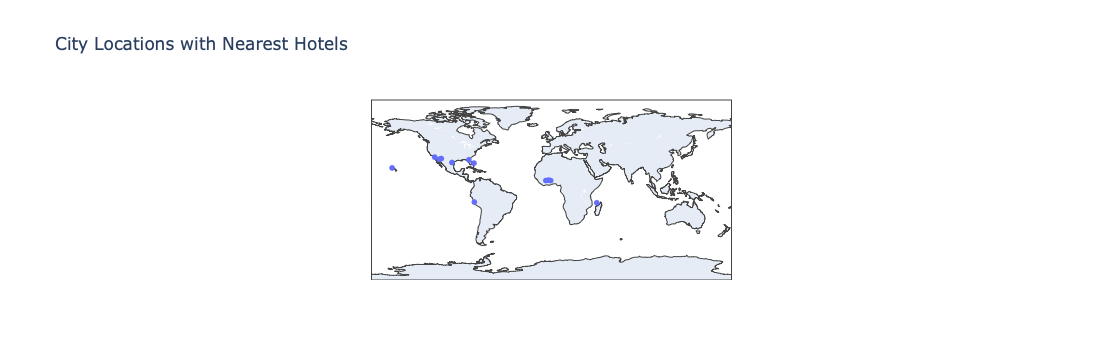

In [27]:
%%capture --no-display

# Configure the map plot
fig = px.scatter_geo(
    filtered_city_data_df,
    lat='Lat',
    lon='Lng',
    hover_name='City',
    hover_data={
        'Country': True,  
        'Hotel Name': hotel_df['Hotel Name'], 
        'Max Temp': True,  
        'Humidity': True,   
    },
    title='City Locations with Nearest Hotels',
    template='plotly',
)


# Display the map
fig.show()